In [2]:
import numpy as np
import torch 
import scipy.stats
import math
from scipy.stats import multivariate_normal
from torch import distributions
from matplotlib.pylab import plt
import pymc3 as pm
import random
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score, roc_curve, auc
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
import torch.nn.functional as F


In [20]:
def ROC(y_test, y_prob):

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.figure(figsize = (10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

# Model 4

$\ Y_i $ ~ $Bernoulli(1/2)$\
$\ Z_{it}|Z_{i,t-1}, Y_i$ ~ $\ N$($0.9 Z_{i,t-1}$,$50.1^{Y_i}$)\
$\ X_{it}|Z_{i,t}$ ~ $\ Categorical$($\sigma(\Psi Z_{i,t}$))\



## 1. Data Simulation

In [4]:
# structural constants
xdim = 100  # number of billing codes
N = 2000  # number of patients
T = 2  # total time steps

# model parameters
success_prob = 0.5
Psi = torch.arange(0, xdim * 0.01, 0.01)
Omega = torch.tensor((1., 50.1))

# random variables
Z_true = torch.zeros((N, T)) # latent 
X = torch.zeros((N, T)) # observed
X_onehot = torch.zeros((N, T, xdim))
Y = torch.distributions.Bernoulli(success_prob).sample((N,))

for t in range(0,T):
    # Zit | Zi,t-1, Yi
    meanz = (0.9 * Z_true[:, t - 1]) if t != 0 else torch.zeros((N,))
    zvar_true = Omega[0] * (1 - Y) + Omega[1] * Y
    Zt = Normal(meanz, zvar_true.sqrt())
    Z_true[:, t] = Zt.sample()

    # Xit | Zit
    Psi_z = Z_true[:,t].view(N, 1) * Psi.view(1, xdim)
    PX = F.softmax(Psi_z, dim = 1)
    Xt = Categorical(PX)
    Xit = Xt.sample()
    X[:, t] = Xit
    X_onehot[:, t] = F.one_hot(Xit, num_classes = xdim)

## 2. Train-Test Split

In [5]:
idx = torch.randperm(N)
train_idx = idx[:math.floor(0.8*N)]
test_idx = idx[math.floor(0.8*N):]
X_train = X_onehot[train_idx,:,:]
X_test = X_onehot[test_idx,:,:]
xd1, xd2, xd3 = X_train.shape
X_train_lr = X_train.view(xd1, xd2*xd3)
xd1, xd2, xd3 = X_test.shape
X_test_lr = X_test.view(xd1, xd2*xd3)

In [6]:
y_train = Y[train_idx]
y_test = Y[test_idx]

## 3. Logistic Regression

In [7]:
lr_accuracy = torch.zeros(T)

clf = LogisticRegression().fit(X_train_lr, y_train)
y_prob_lr = clf.predict_proba(X_test_lr)[:,1]
y_pred_lr = 1*(y_prob_lr > 0.5)

lr_accuracy = accuracy_score(y_test,y_pred_lr)

In [8]:
print("Logistic regression accuracy in test:", lr_accuracy)

Logistic regression accuracy in test: 0.6325


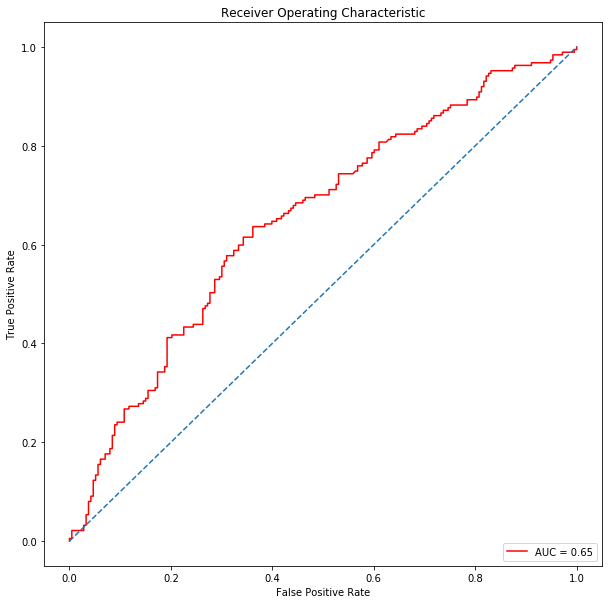

In [9]:
ROC(y_test, y_prob_lr)

## 4. Numerical integration approach (IS)

$\ Z_{it}^{(k)}|Z_{i,t-1}^{(k)}, Y_i$ ~ $\ N$($0.9 Z_{i,t-1}^{(k)}$,$50.1^{Y_i}$)\
$\ X_{it}|Z_{i,t}$ ~ $\ Categorical$($\sigma(\Psi Z_{i,t}$))

$P(X|Y = 1) = E_{P(Z|Y = 1)} [P(X|Z)] \approx \frac{1}{K} \sum_{k=1}^{K} P(X|Z^{(k)}),  Z^{(k)} \sim P(Z^{(k)}|Y = 1)$\
$P(X|Y = 0) = E_{P(Z|Y = 0)} [P(X|Z)] \approx \frac{1}{K} \sum_{k=1}^{K} P(X|Z^{(k)}),  Z^{(k)} \sim P(Z^{(k)}|Y = 0)$

$P(Y = 1 |X) = \frac{P(X|Y = 1)P(Y=1)}{P(X|Y = 1)P(Y=1) + P(X|Y = 0)P(Y=0)}$

### 4.1 Inference Z and X generation
$\ Z_{it}^{(k)}|Z_{i,t-1}^{(k)}, Y_i$ ~ $\ N$($0.9 Z_{i,t-1}^{(k)}$,$50.1^{Y_i}$)\
$\ X_{it}|Z_{i,t}$ ~ $\ Categorical$($\sigma(\Psi Z_{i,t}$))


In [10]:
K = 1000 # number of simulations

Z = torch.zeros((K, N, T)) 
logPX_y = torch.zeros((2, K, N, T))

for t in range(0, T):
    for y in range(2):
        # Zit | Zi,t-1, y
        meanz = (0.9 * Z[:, :, t - 1]) if t != 0 else torch.zeros((K, N))
        var_y = Omega[y]
        Zt = Normal(meanz, var_y.sqrt())
        Z[:, :, t] = Zt.sample()

        # Xit | Zit
        Psi_z = Z[:, :, t].view(K, N, 1) * Psi.view(1, 1, xdim)
        PX = F.softmax(Psi_z, dim = 2)
        Xt = Categorical(PX)
        logPX_y[y, :, :, t] = Xt.log_prob(X[:, t])

### 4.2 Approximate P(X|Y)
$P(X|Y = 1) = E_{P(Z|Y = 1)} [P(X|Z)] \approx \frac{1}{K} \sum_{k=1}^{K} P(X|Z^{(k)}),  Z^{(k)} \sim P(Z^{(k)}|Y = 1)$\
$P(X|Y = 0) = E_{P(Z|Y = 0)} [P(X|Z)] \approx \frac{1}{K} \sum_{k=1}^{K} P(X|Z^{(k)}),  Z^{(k)} \sim P(Z^{(k)}|Y = 0)$


In [11]:
ElogPX_1k = torch.logsumexp(logPX_y[1], dim = 0) - np.log(K)
ElogPX_1 = torch.mean(ElogPX_1k,dim = 1)

ElogPX_0k = torch.logsumexp(logPX_y[0], dim = 0) - np.log(K)
ElogPX_0 = torch.mean(ElogPX_0k,dim = 1)

### 4.3 Posterior distribution
$P(Y = 1 |X) = \frac{P(X|Y = 1)P(Y=1)}{P(X|Y = 1)P(Y=1) + P(X|Y = 0)P(Y=0)}$

In [12]:
logPX_Y1 = ElogPX_1 + np.log(success_prob)
logPX_Y0 = ElogPX_0 + np.log(1-success_prob)
logPY1_X = logPX_Y1 - (logPX_Y1.exp() + logPX_Y0.exp()).log()
logPY1_X.exp()
Y_pred = 1*(logPY1_X.exp() > 0.5)

In [13]:
print("Numerical integration classification accuracy in testing:",torch.mean((Y_pred[test_idx] == y_test).float()).item())

Numerical integration classification accuracy in testing: 0.612500011920929


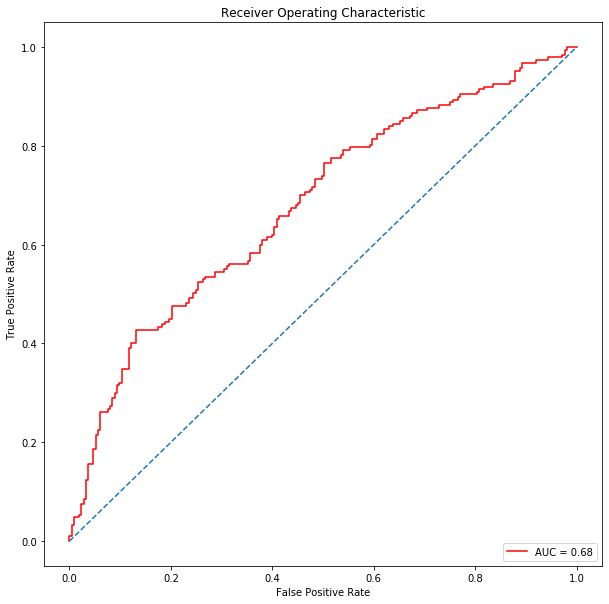

In [14]:
ROC(y_test, logPY1_X.exp()[[test_idx]])

# Model 5


$\ Z_{it}|Z_{i,t-1}$ ~ $\ N$($0.9 Z_{i,t-1}$,$1$)\
$\exists t, \ Y_i | Z_i = \mathcal{I} \{Z_{i,t} \in [1,3]\} * \mathcal{I} \{Z_{i,t-1} \in [1,3]\} * \mathcal{I} \{Z_{i,t-2} \in [1,3]\} $\
$\ X_{it}|Z_{i,t}$ ~ $\ Categorical$($\sigma(\Psi Z_{i,t}$))

### 1. Data Simulation

In [28]:
xdim = 100  # number of billing codes
N = 2000  # number of patients
T = 5  # total time steps

# model parameters
Psi = torch.arange(0, xdim * 0.01, 0.01)

# random variables
Z_true = torch.zeros((N, T)) # latent 
X = torch.zeros((N, T)) # observed
X_onehot = torch.zeros((N, T, xdim))
Y = torch.zeros((N,))

for t in range(0,T):
    # Zit | Zi,t-1, Yi
    meanz = (0.9 * Z_true[:, t - 1]) if t != 0 else torch.zeros((N,))
    Zt = Normal(meanz, 1)
    Z_true[:, t] = Zt.sample()
    
    # Xit | Zit
    Psi_z = Z_true[:,t].view(N, 1) * Psi.view(1, xdim)
    PX = F.softmax(Psi_z, dim = 1)
    Xt = Categorical(PX)
    Xit = Xt.sample()
    X[:, t] = Xit
    X_onehot[:, t] = F.one_hot(Xit, num_classes = xdim)

for i in range(N):
    for j in range (T-2):
        Y[i] = Y[i] + (Z_true[i,j] >= 1) * (Z_true[i,j] <= 3) * (Z_true[i,j+1] >= 1) \
            * (Z_true[i,j+1] <= 3) * (Z_true[i,j+2] >= 1) * (Z_true[i,j+2] <= 3)
    Y[i] = min(Y[i], 1)

In [29]:
Y.sum()

tensor(260.)

### 2. Train-Test split

In [30]:
idx = torch.randperm(N)
train_idx = idx[:math.floor(0.8*N)]
test_idx = idx[math.floor(0.8*N):]
X_train = X_onehot[train_idx,:,:]
X_test = X_onehot[test_idx,:,:]
xd1, xd2, xd3 = X_train.shape
X_train_lr = X_train.view(xd1, xd2*xd3)
xd1, xd2, xd3 = X_test.shape
X_test_lr = X_test.view(xd1, xd2*xd3)
y_train = Y[train_idx]
y_test = Y[test_idx]

### 3. Logistic regression

In [31]:
lr_accuracy = torch.zeros(T)

clf = LogisticRegression().fit(X_train_lr, y_train)
y_prob_lr = clf.predict_proba(X_test_lr)[:,1]
y_pred_lr = 1*(y_prob_lr > 0.5)

lr_accuracy = accuracy_score(y_test,y_pred_lr)

In [32]:
print("Logistic regression accuracy in test:", lr_accuracy)

Logistic regression accuracy in test: 0.845


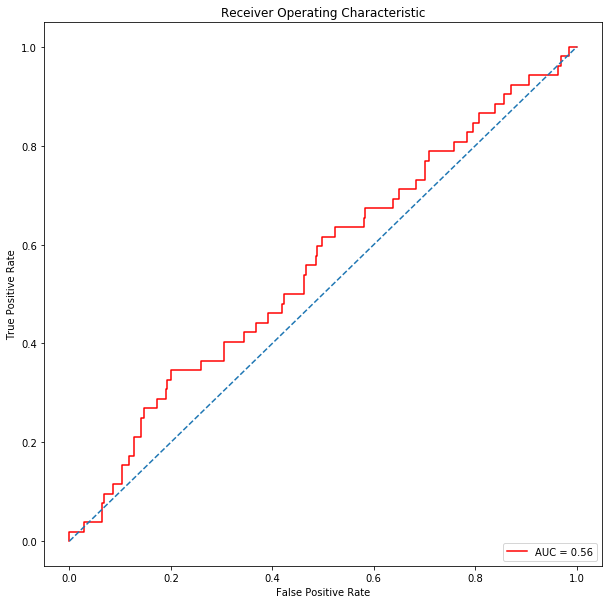

In [33]:
ROC(y_test, y_prob_lr)

### 4. Importance Sampling approach

$\ Z_{it}^{(k)}|Z_{i,t-1}^{(k)}, Y_i$ ~ $\ N$($0.9 Z_{i,t-1}^{(k)}$,$1$)\
$\ X_{it}|Z_{i,t}$ ~ $\ Categorical$($\sigma(\Psi Z_{i,t}$))

$P(X|Y = 1) = E_{P(Z|Y = 1)} [P(X|Z)] \approx \frac{1}{K} \sum_{k=1}^{K} P(X|Z^{(k)}),  Z^{(k)} \sim P(Z^{(k)}|Y = 1)$\
$P(X|Y = 0) = E_{P(Z|Y = 0)} [P(X|Z)] \approx \frac{1}{K} \sum_{k=1}^{K} P(X|Z^{(k)}),  Z^{(k)} \sim P(Z^{(k)}|Y = 0)$

$P(Y = 1 |X) = \frac{P(X|Y = 1)P(Y=1)}{P(X|Y = 1)P(Y=1) + P(X|Y = 0)P(Y=0)}$